## Set up Workshop

In [91]:
reset -fs

In [92]:
## Import Libraries
# DataFrames
import pandas as pd
# Numpy-Arrays and Array Math
import numpy as np
# Basic Visualization
import matplotlib.pyplot as plt
# Functions creating iterators for efficient looping
import itertools

## Import Functins
# Split Data into Train and Test Data
from sklearn.model_selection import train_test_split
# The "Random Forest Classifier"
from sklearn.ensemble import RandomForestClassifier
# Precision Score Calculator
from sklearn.metrics import precision_score
# Recall Score Calculator
from sklearn.metrics import recall_score
# ROC/AUC Score Calculator
from sklearn.metrics import roc_auc_score
# ROC Curve
from sklearn.metrics import roc_curve
# Confusion Matrix
from sklearn.metrics import confusion_matrix

## Other
# Fixate Random Seed
RSEED = 50
# Choose Visualization Style
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

## Data Mining

In [93]:
## Import Data
# Full dataset: https://www.kaggle.com/cdc/behavioral-risk-factor-surveillance-system
source_path = 'https://s3.amazonaws.com/projects-rf/clean_data.csv'
data_raw = pd.read_csv(source_path)

In [94]:
## Hand over Data to Data Janitorial Service
data_djs = data_raw

## Data Cleaning

### Handling Missing Values

In [95]:
## Fill Missing Values with Mean of Feature
data_djs = data_djs.fillna(data_djs.mean())

In [96]:
## Hand over Data to Engineering
data_eng = data_djs

## Engineering

In [97]:
## Seperate independent variable from dependent variable
# Set Target
target = 'label'
# Extract Target
labels = data_eng.pop(target)
# Turn Target into Numpy Array
labels = np.array(labels)

In [98]:
## Seperate Data into Training and Testing Data
t2t_ratio = 0.3
train, test, train_labels, test_labels = train_test_split(data_eng,
                                         labels, 
                                         stratify = labels,
                                         test_size = t2t_ratio, 
                                         random_state = RSEED)

In [99]:
# Create List of the dependent features
features = list(train.columns)

In [100]:
## Set up Random Forrest Classifiing Machine
# Number of Trees
forrest_size = 100
# The number of features to consider when looking for the best split
consideration_ratio = 'sqrt'
# Set Number of Processor to use (-1 : "EVERYONE!!!)
processors = -1
# Set Verbosity 
verbosity = 1
# Create Machine
model = RandomForestClassifier(n_estimators = forrest_size, 
                               random_state = RSEED, 
                               max_features = consideration_ratio,
                               n_jobs       = processors,
                               verbose      = verbosity)

In [101]:
# Feed Training Data to Machine
model.fit(train, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.3s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=50, verbose=1, warm_start=False)

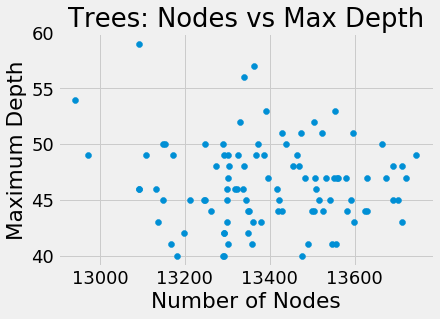

Average number of nodes 13396
Average maximum depth 46


In [102]:
## Gain Insight into Trees
# Set up Vault for Number of Nodes
n_nodes = []
# Set up Vault for Debth of Tree
max_depths = []
# Cycle through each individual Tree of the Forrest
for ind_tree in model.estimators_:
    # Extract Number of Nodes and store it in according vault
    n_nodes.append(ind_tree.tree_.node_count)
    # Extract Depth of Tree and store it in according vault
    max_depths.append(ind_tree.tree_.max_depth)
# Out of Curiosity: Plot Results
plt.scatter (n_nodes,max_depths)    
plt.title   ("Trees: Nodes vs Max Depth")
plt.xlabel  ("Number of Nodes")
plt.ylabel  ("Maximum Depth")
plt.show()    
# Print Results   
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

In [103]:
# Make Prediction with Traning Data
train_rf_predictions = model.predict(train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.8s finished


In [104]:
# Determine Certainty of Training Data Prediction (= Probability of "1" Result)
train_rf_probs = model.predict_proba(train)[:, 1]

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.8s finished


In [105]:
# Make Prediction with Testing Data
rf_predictions = model.predict(test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished


In [106]:
# Determine Certainty of Training Data Prediction  (= Probability of "1" Result)
rf_probs = model.predict_proba(test)[:, 1]

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished


In [107]:
## Define Function for elvaluation the model
# Porpuse: Compute Statistics and plot ROC Curve
# Input: Predicted Values, Probability of Values (both for Testing and Treining Data)

def evaluate_model(predictions, probs, train_predictions, train_probs):
    # Baseline Information
    # Set up Vault for baseline data  
    baseline = {}
    # Put Recall Values into Vault
    baseline['recall'] = recall_score(test_labels, 
                                     [1 for _ in range(len(test_labels))])
    # Put Precision Value into Vault
    baseline['precision'] = precision_score(test_labels, 
                                      [1 for _ in range(len(test_labels))])
    # Set ROC Value, put into Vault
    baseline['roc'] = 0.5

    ## Testing Data
    # Set up vault for testing data  
    results = {}
    # Put Recall Values into Vault   
    results['recall'] = recall_score(test_labels, predictions)
    # Put Precision Value into Vault
    results['precision'] = precision_score(test_labels, predictions)
    # Set ROC Value, put into Vault   
    results['roc'] = roc_auc_score(test_labels, probs)
    
    ## Training Data
    # Set up vault for training data   
    train_results = {}
    # Put Recall Values into Vault  
    train_results['recall'] = recall_score(train_labels, train_predictions)
    # Put Precision Value into Vault
    train_results['precision'] = precision_score(train_labels, train_predictions)
    # Set ROC Value, put into Vault   
    train_results['roc'] = roc_auc_score(train_labels, train_probs)

    # Calculate and Print Metrics 
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    ## Create Plot
    # Set up Plot    
    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    # Plot Curves (Baseline and Model)
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); 
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();

Recall Baseline: 1.0 Test: 0.96 Train: 1.0
Precision Baseline: 0.81 Test: 0.88 Train: 1.0
Roc Baseline: 0.5 Test: 0.87 Train: 1.0


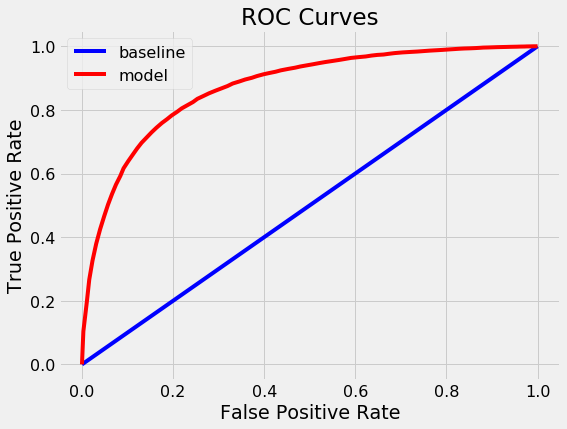

<Figure size 432x288 with 0 Axes>

In [108]:
# Evaluate Model
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)
# Save Picture
plt.savefig('roc_auc_curve.png')

In [109]:
## Define Function to print anf plot confusion matrix
# Inputs: Confusion Matrix, Name of Classes, normalize yes/no, Title of Plot, Colorscheme

def plot_confusion_matrix(cm,
                          classes,
                          normalize = False,
                          title     = 'Confusion matrix',
                          cmap      = plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    # Normalization, if requested
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[ 2419  3155]
 [ 1036 23306]]


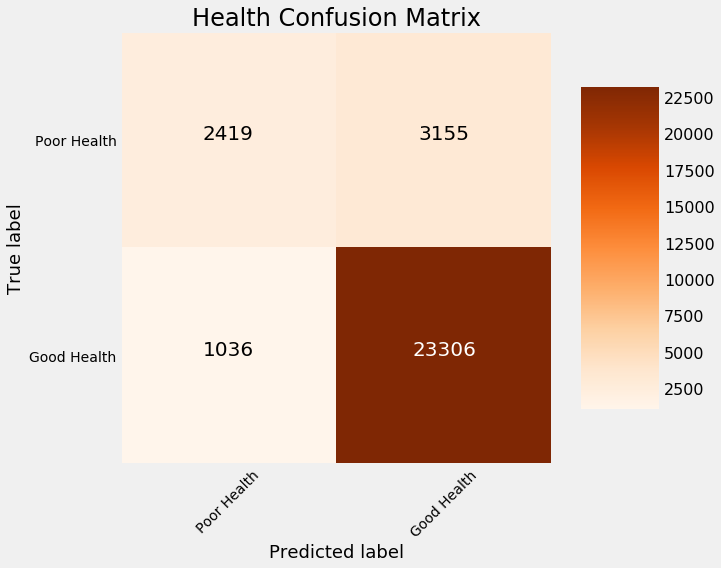

In [110]:
## Visualize Model Prediction Evaluation via Heatmap
# Set up input
actual_label = test_labels
predicted_label = rf_predictions
names = ['Poor Health', 'Good Health']
title = 'Health Confusion Matrix'
# Set up Confusion Matrix with input
cm = confusion_matrix(actual_label,
                      predicted_label)
# Plot Confusion Matrix
plot_confusion_matrix(cm,
                      classes = names,
                      title = title)
# Save Plot
plt.savefig('cm.png')